# AI4EO - Feature enhancement for land management

## Get started with the challenge

This notebook will get you started with downloading, exploring and analysing the input and output data of the challenge.

The aim of this challenge is to create AI systems that can exploit the temporal information of Sentinel-2 images into an enhanced spatial resolution. 

Your task will be to estimate a _cultivated land_ map at **2.5m** spatial resolution given as input a _Sentinel-2 time-series_ at **10m** spatial resolution, therefore resulting in a `4x` spatial resolution improvement. 

This notebook showcases how to download and process the data using [eo-learn](https://eo-learn.readthedocs.io/en/latest/index.html), a Python library specifically designed deal with Earth Observation data. The data will stored into `EOPatches` as `numpy` arrays and `geopandas` dataframes to facilitate processing operations. However, you can use any other Python tool of preference to process the provided data.

The notebook also showcases how to generate a valid submission file.

As per challenge rules, the following applies:
 * no data source other than the ones provided can be used to produce your outputs;
 * pre-trained models are not allowed;
 * the test data cannot be used for training of the models; 
 * the target _cultivated land_ map cannot be used as an input to the method (i.e. trivial solution).

Code for the winning solutions will be reviewed to ensure rules have been followed.

The content of the notebook is as follows:

0. [Requirements](#requirements)

1. [Data overview](#data-overview)

   1.1. [Area of Interest](#aoi)

   1.2. [Sentinel-2 time-series](#sentinel-2)
     
   1.3. [Reference polygons](#reference)
   
   1.4. [Data download](#data-download)
      
2. [Data processing](#data-processing)

3. [Submission example](#submission-example)

   3.1 [Prepare a submission](#prepare-a-submission)

In [4]:
# ensure you have the latest eo-learn-io and sentinlhub version
!pip install --upgrade eo-learn
!pip install --upgrade sentinelhub
#!pip install --upgrade geopandas
#! conda install -c conda-forge xcube_geodb 

/local_home/kuzu_ri/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Built-in modules
import os
import json
from typing import Tuple, List
from datetime import datetime, timedelta

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask
from eolearn.geometry import VectorToRaster

# Visualisation utils
from utils import get_extent, md5_encode_files

## 0. Requirements  <a name="requirements"></a>

In order to download the data through the provided APIs you would need to set-up an account for Sentinel Hub and GeoDB. Check the following options.

#### If you are using the Euro Data Cube (EDC) resources

The accounts have been already created and configured for you, and what you need is only to retrieve the SentinelHub credentials from your dashboard and paste them below (from your EDC dashboard click on **EDC Sentinel Hub** in the _My API service subscriptions_, then click on **SHOW** credential in _API Access_ section).  

#### If you are using your own resources

You need the following accounts:

 * [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/), to download the Sentinel-2 time-series. What you need is to [create a free account](http://www.sentinel-hub.com/create_account), register an OAuth client from [your dashboard](https://apps.sentinel-hub.com/dashboard/#/account/settings) by clicking on the `Create a new OAuth client` button, set the `Client grant type` to `Client Credentials` and save the `secret` value. Paste below the `client_id` and `secret_client_id` and you are ready to go;
 * [GeoDB](https://eurodatacube.com/marketplace/services/edc_geodb), to download polygons defining the AOI and the reference land cover polygons. [Create a trial account](https://eurodatacube.com/register), and retrieve the `client_id` and `client_secret` tokens from your dashboard. 
 
#### If you cannot use the APIs

Check the challenge description for alternative options to retrieve the data as a single zipped file. Beware that the resulting dataset is approximately 7GB. 

Replace the `'xx'` with your Sentinel Hub credentials.

In [13]:
sh_client_id = '45a78949-8412-4ff6-a59f-c9f5597bd33f'
sh_client_secret = 'F%hj|pF,>q]bXv_:8t<5S5E]yn5#VsnVJ:wCNK+@'

sh_config = SHConfig()
sh_config.sh_client_id = sh_client_id
sh_config.sh_client_secret = sh_client_secret

Replace the `'yy'` with your GeoDB credentials (not necessary if you are running from EDC).

In [14]:
geodb_client_id = 'yyy'
geodb_client_secret = 'yyYYyy'

# uncomment below if running from EDC
client = GeoDBClient()

# uncomment below if running from your own resources
#client = GeoDBClient(server_url='https://xcube-geodb.brockmann-consult.de', 
#                     auth_aud='https://xcube-users.brockmann-consult.de/api/v2', 
#                     client_id=geodb_client_id, client_secret=geodb_client_secret)

client.whoami

GeoDBError: System: Invalid client_credentials configuration.

## 1. Data Overview <a name="data-overview"></a>

This section gives an overview of all the necessary data to train your model and how to download them. 

In particular, the data sources to download are the following:

 * a list of bounding boxes defining the area-of-interest (AOI);
 * the Sentinel-2 L2A time-series for a 6 months period;
 * the reference polygons defining the cultivated and non-cultivated land labels. 
 
After downloading the bounding boxes defining the AOI, we will donwload the images and reference data for an example bounding box. After this, we will set a workflow to download all the required data.

In [9]:
# DO NOT CHANGE THIS
GEODB_DATABASE = 'geodb_0e5d743f-2134-4561-8946-a073b039176f'

### 1.1 Area of Interest <a name="aoi"></a>

The AOI chosen for this challenge is the [Republic of Slovenia](https://en.wikipedia.org/wiki/Slovenia). 

The AOI is split into 125 bounding boxes across the entire country, data for 100 bounding boxes to be used for training, and 25 for testing. The following code retrieves the bounding boxes from the GeoDB database.

`bboxes` is a `geopandas` GeoDataFrame holding information on whether the bounding box has to be used for training/testing, i.e. `is_train` column, and a unique index identifier of the bounding box, i.e. `eop_index`.

In [10]:
bboxes = client.get_collection('ai4eo_bboxes', database=GEODB_DATABASE)

HTTPError: 404 Client Error: NOT FOUND for url: https://xcube-users.brockmann-consult.de/api/v2/oauth/token

**NOTE:** The bounding boxes and all data sources used are in the UTM zone 33N, i.e. `epsg:32633`.

In [8]:
bboxes.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Plot bounding boxes

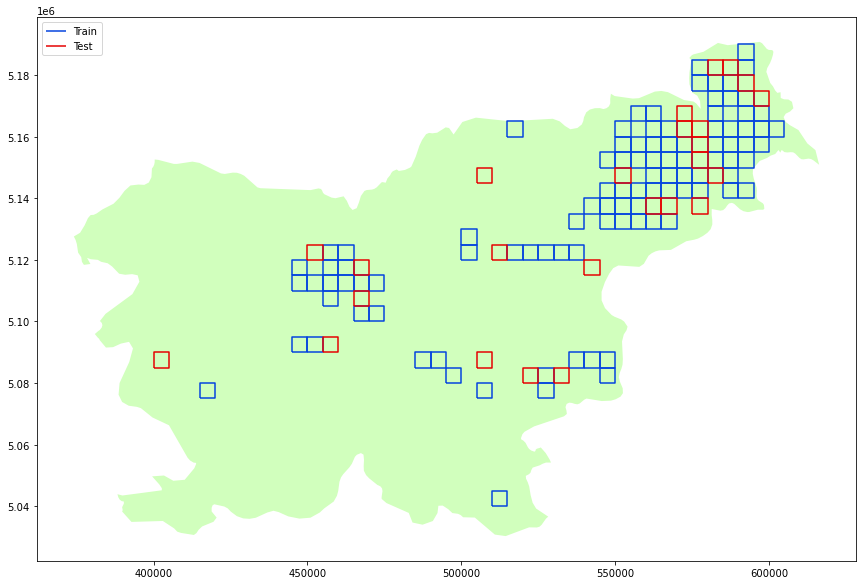

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
gpd.read_file('metadata/svn-border.geojson').plot(ax=ax, color='xkcd:very light green')
bboxes.query('is_train==True').boundary.plot(ax=ax, color='xkcd:blue', label='Train');
bboxes.query('is_train==False').boundary.plot(ax=ax, color='xkcd:red', label='Test');
ax.legend(loc='upper left');

Get indices defining the train/test bounding boxes, as these will be used to name our EOPatches.

In [10]:
eops_train = bboxes.query('is_train==True').eop_index.values
eops_test = bboxes.query('is_train==False').eop_index.values

In [11]:
len(eops_train), np.sort(eops_train)

(100, array([153, 294, 298, 299, 316, 320, 341, 342, 343, 344, 363, 364, 365,
        381, 383, 402, 404, 471, 498, 523, 558, 559, 577, 599, 644, 652,
        672, 688, 689, 697, 718, 731, 738, 740, 751, 761, 770, 771, 780,
        781, 782, 784, 799, 800, 801, 803, 804, 805, 811, 812, 813, 815,
        816, 818, 823, 825, 826, 827, 828, 829, 830, 835, 837, 838, 839,
        840, 841, 849, 850, 851, 852, 862, 863, 869, 870, 877, 878, 879,
        880, 881, 882, 887, 888, 889, 890, 891, 893, 894, 899, 901, 902,
        903, 904, 905, 907, 908, 914, 915, 916, 924]))

In [12]:
len(eops_test), np.sort(eops_test)

(25, array([ 81, 322, 338, 382, 384, 579, 591, 615, 664, 710, 757, 802, 824,
        836, 853, 854, 861, 864, 865, 866, 876, 883, 895, 906, 917]))

### 1.2 Sentinel-2 time-series <a name="sentinel-2"></a>

The input images are Sentinel-2 L2A acquired over a 6-months period, from March 1st to September 1st 2019. 

The following data will be downloaded:

 * `BANDS`: all 12 Sentinel-2 L2A bands. The bands are in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options); 
 * `SCL`: Sen2Cor scene classification mask;
 * `IS_DATA`: binary mask denoting data/no-data pixels;
 * `CLP`, `CLM`: `s2cloudless` cloud probability and cloud mask. More details about these layers can be found [here](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/).
 
More details about the bands can be found [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

In [13]:
# Download parameters - DO NOT CHANGE
S2_TIME_INTERVAL = ('2019-03-01','2019-09-01')

S2_RESOLUTION = 10 #metres
S2_MAXCC = 0.5
S2_TIME_DELTA = 120

MAX_THREADS = 5

Example download for the first bounding box.

In [14]:
bbox = BBox(bboxes.iloc[0].geometry, crs=CRS(bboxes.crs))

`eo-learn` task to download images from SentinelHub.

In [15]:
get_s2_l2a = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands_dtype=np.uint16,
    resolution=S2_RESOLUTION,
    maxcc=S2_MAXCC,
    time_difference=timedelta(minutes=S2_TIME_DELTA),
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'SCL'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=MAX_THREADS,
    config=sh_config
)

Download images for given `bbox` and `time_interval`.

In [16]:
%%time
s2_l2a_eop = get_s2_l2a.execute(bbox=bbox, time_interval=S2_TIME_INTERVAL)

CPU times: user 5.96 s, sys: 781 ms, total: 6.75 s
Wall time: 57.1 s


The data is now stored in an [EOPatch](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch), where each raster feature is stored as a `numpy` array, vector data stored as a `geopandas` dataframe, while dates as `datetime` objects.

This `EOPatch` contains 38 time frames, of `500x500` spatial dimension. All `EOPatches` will have same spatial dimensions, but different temporal frames.

**NOTE:** Band values are stored as digital numbers `DN`s, therefore they need to be mulitplied by the `NORM_FACTORS` (i.e. `1e-4`) to derive reflectances.

In [17]:
s2_l2a_eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((585000.0, 5180000.0), (590000.0, 5185000.0)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2019, 3, 4, 10, 6, 2, tzinfo=tzutc()), ...], length=38
)

In [18]:
scl_dict =  {0: [0, 0, 0], # no data
             1: [1, 0, 0.016], # saturated / defected
             2: [0.525, 0.525, 0.525], # dark area pixels
             3: [0.467, 0.298, 0.043], # cloud shadows
             4: [0.063, 0.827, 0.176], # vegetation
             5: [1, 1, 0.325], # bare soils
             6: [0, 0, 1], # water
             7: [0.506, 0.506, 0.506], # clouds low probability / unclassified 
             8: [0.753, 0.753, 0.753], # clouds medium probability
             9: [0.949, 0.949, 0.949], # clouds high probaility
             10: [0.733, 0.773, 0.925], # cirrus
             11: [0.325, 1, 0.980] # ice / snow
           }

Visualise data in `EOPatch`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


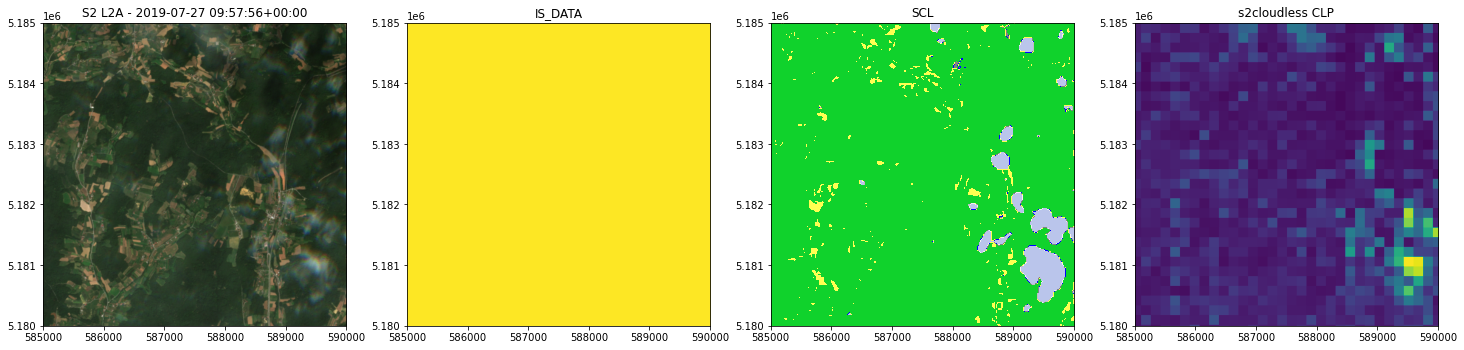

In [19]:
# choos one time index [0..37] to visualise
tidx = 28

vis_factor = 3.5

norm_factor = s2_l2a_eop.scalar['NORM_FACTORS'][tidx]

fig, axs = plt.subplots(figsize=(25, 6), ncols=4)

axs[0].imshow(vis_factor*s2_l2a_eop.data['BANDS'][tidx][..., [3, 2, 1]]*norm_factor,
              extent=get_extent(s2_l2a_eop));
axs[0].set_title(f'S2 L2A - {s2_l2a_eop.timestamp[tidx]}');

axs[1].imshow(s2_l2a_eop.mask['IS_DATA'][tidx].squeeze(), 
              vmin=0, vmax=1, extent=get_extent(s2_l2a_eop));
axs[1].set_title('IS_DATA');

axs[2].imshow(s2_l2a_eop.mask['SCL'][tidx].squeeze(), 
              extent=get_extent(s2_l2a_eop), 
              cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11);
axs[2].set_title('SCL');

axs[3].imshow(s2_l2a_eop.data['CLP'][tidx].squeeze()/255, vmin=0, vmax=1,
              extent=get_extent(s2_l2a_eop));
axs[3].set_title('s2cloudless CLP');

The information in the provided masks can be used to mask out invalid frames containing clouds/snow/fog. Below an example using `IS_DATA` and `CLM` mask to find the percentage of valid data in the 6-months period.

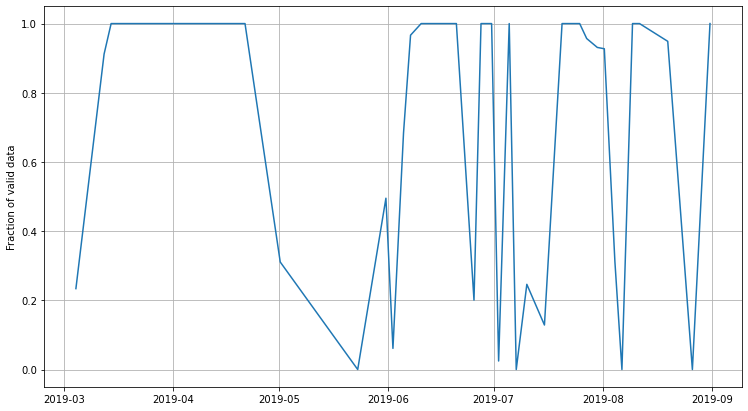

In [20]:
valid_data = np.mean(s2_l2a_eop.mask['IS_DATA'] & ~s2_l2a_eop.mask['CLM'], 
                     axis=(1,2,3)) 

fig, ax = plt.subplots(figsize=(12.5, 7))
ax.plot(s2_l2a_eop.timestamp, valid_data)
ax.set_ylabel('Fraction of valid data')
ax.grid()

Number of frames for this EOPatch with fraction of valid data greater than 90%. The `SCL` mask and `CLP` masks can be similarly used to estimate data validity fractions.

In [21]:
np.sum(valid_data>.9)

24

### 1.3 Reference polygons <a name="reference"></a>

Now that we have the Sentinel-2 time-series data, time to add the information about the target _cultivated land_ map. This mask is derived from a combination of a _land cover_ dataset and a _declared crops_ dataset.

The reference data is stored as polygons in a GeoDB table. The following task retrieves the polygons within each bounding box defined above.

In [22]:
get_polys = GeoDBVectorImportTask(
    feature=(FeatureType.VECTOR_TIMELESS, 'REFERENCE'), 
    geodb_client=client, 
    geodb_collection='ai4eo_reference',
    geodb_db=GEODB_DATABASE
)

Execute the task and create a new `VECTOR_TIMELESS` feature holding the polys as a `geopandas` dataframe.

In [23]:
eop = get_polys.execute(eopatch=s2_l2a_eop)

In [24]:
eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=6224, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((585000.0, 5180000.0), (590000.0, 5185000.0)), crs=CRS('32633'))
  timest

In [25]:
eop.vector_timeless['REFERENCE'].head()

,id,created_at,modified_at,geometry,label
0,1,2021-04-30T06:06:22.242982+00:00,None,"POLYGON ((587075.534 5180807.041, 587006.804 5...",1
1,2,2021-04-30T06:06:22.242982+00:00,None,"POLYGON ((585436.626 5181893.156, 585454.317 5...",1
2,3,2021-04-30T06:06:22.242982+00:00,None,"POLYGON ((589320.521 5181989.978, 589328.939 5...",1
3,4,2021-04-30T06:06:22.242982+00:00,None,"POLYGON ((585374.299 5184736.745, 585369.919 5...",1
4,5,2021-04-30T06:06:22.242982+00:00,None,"POLYGON ((585288.649 5180000.000, 585290.806 5...",1


Each polygon has a `label` attribute which denotes its land cover. Values between 1 and 30 denote _agricultural land_ including grassland and meadows, values above 1000 denote land cover types like _water_, _forest_ and _build-up_ area, while the label 100 denotes _agricultural land_ of which the crop-type is unknown.

In [26]:
eop.vector_timeless['REFERENCE'].label.unique()

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   18,   20,   23,   24,   27,   30,  100,
       1410, 1420, 1500, 1600, 1800, 2000, 3000, 7000])

In [27]:
df = eop.vector_timeless['REFERENCE']

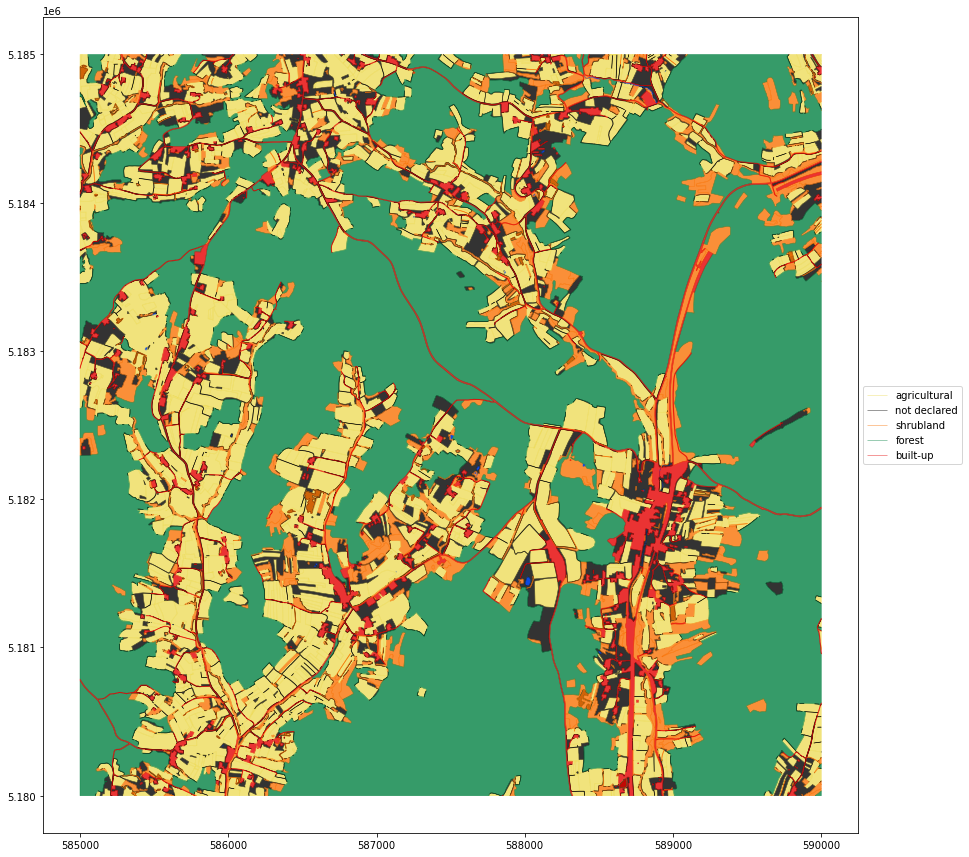

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))

df.query('label<=30').plot(ax=ax, color='xkcd:dull yellow', alpha=.8);
df.query('label<=30').boundary.plot(ax=ax, color='xkcd:dull yellow',  alpha=.8, linewidth=.5, label='agricultural');

df.query('label==100').plot(ax=ax, color='xkcd:black', alpha=.8);
df.query('label==100').boundary.plot(ax=ax, color='xkcd:black',  alpha=.8, linewidth=.5, label='not declared');

df.query('(label>1000) and (label<2000)').plot(ax=ax, color='xkcd:orange', alpha=.8);
df.query('(label>1000) and (label<2000)').boundary.plot(ax=ax, color='xkcd:orange',  alpha=.8, linewidth=.5, label='shrubland');

df.query('label==2000').plot(ax=ax, color='xkcd:jungle green', alpha=.8);
df.query('label==2000').boundary.plot(ax=ax, color='xkcd:jungle green',  alpha=.8, linewidth=.5, label='forest');

df.query('label==3000').plot(ax=ax, color='xkcd:red', alpha=.8);
df.query('label==3000').boundary.plot(ax=ax, color='xkcd:red', alpha=.8, linewidth=.5, label='built-up');

# # no values in this EOPatch
# df.query('(label>4000) and (label<=5000)').plot(ax=ax, color='xkcd:bright teal', alpha=.8);
# df.query('(label>4000) and (label<=5000)').plot(ax=ax, color='xkcd:bright teal', alpha=.8, linewidth=.5, label='wetland');

# # no values in this EOPatch
# df.query('label==6000').plot(ax=ax, color='xkcd:grey', alpha=.8);
# df.query('label==6000').plot(ax=ax, color='xkcd:grey', alpha=.8, linewidth=.5, label='bareland');

df.query('label==7000').plot(ax=ax, color='xkcd:blue', alpha=.8);
df.query('label==7000').plot(ax=ax, color='xkcd:blue', alpha=.8, linewidth=.5, label='water');

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Names of labels and labels mapping to a binary _cultivated/not-cultivated_ mask are provided in the `json` files in the `metadata` folder. 

In the context of this challenge, _cultivated land_ denotes arable land that is typically worked by ploughing, sowing and raising crops.

In [29]:
with open('metadata/cultivated-mapping.json') as jfile:
    cultivated_mapping = {int(k): v for k, v in json.load(jfile).items()}

Labels that will be mapped to _non-cultivated land_. These labels are a union of _agricultural land_ that is **not** cultivated, e.g. grassland/meadows, tree plantations, greenhouses, and _land covers_ that are not _agricultural land_, e.g. build-up area, water, forest, shrubland.

In [30]:
print(cultivated_mapping[0])

[1, 5, 12, 24, 26, 27, 29, 30, 1410, 1420, 1500, 1600, 1800, 2000, 3000, 4100, 4210, 4220, 5000, 6000, 7000]


Labels that will be mapped to _cultivated land_.

In [31]:
print(cultivated_mapping[1])

[2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28]


Special class which denotes agricultural land that is **not** declared as a specific _cultivated land_. These pixels will have similarities to _cultivated land_, although information is missing about the exact parcel features. For this reason, these polygons will **not** be used to compute the validation metrics.

You are free to use these polys as you wish.

In [32]:
print(cultivated_mapping[2])

100


Display names of crops and land cover for each label.

In [33]:
with open('metadata/label-names.json') as jfile:
    label_names = {int(k): v for k, v in json.load(jfile).items()}

_Not-cultivated land_.

In [34]:
for ncl in cultivated_mapping[0]:
    prefix = 'Crop-types' if ncl <100 else 'Land cover'
    print(f'{prefix} for label {ncl}:')
    print(label_names[ncl])
    print()

Crop-types for label 1:
['grass for seed production', 'grass', 'grass - clover mixture', 'meadow', 'clover-grass mixture', 'clover - grass mixture']

Crop-types for label 5:
['clover', 'clover', 'alfalfa', 'alfalfa', 'Persian clover']

Crop-types for label 12:
['land lying fallow', 'grass carpet roll']

Crop-types for label 24:
['crimson clover']

Crop-types for label 26:
['olive tree']

Crop-types for label 27:
['common grape vine for production of wine', 'common grape vine for human consumption (table grape)', 'grape vine, normally not for consumption']

Crop-types for label 29:
['strawberry']

Crop-types for label 30:
['not in use', 'border fence', "the plant is not in contact with the earth's soil", 'apple tree', 'pear tree', 'quince tree', 'pomegranate tree', 'medlar tree', 'jujube tree', 'peach tree', 'nectarine tree', 'plum tree', 'apricot tree', 'cherry tree', 'sour cherry tree', 'common walnut tree', 'hazel shrub', 'almond tree', 'kiwifruit tree', 'persimmon tree', 'chestnut t

_Cultivated land_

In [35]:
for cl in cultivated_mapping[1]:
    prefix = 'Crop-types' if cl <100 else 'Land cover'
    print(f'{prefix} for label {cl}:')
    print(label_names[cl])
    print()

Crop-types for label 2:
['maize for grain', 'maize for silage', 'sorghum', 'sweet corn', 'sorghum for fodder', 'sudan grass']

Crop-types for label 3:
['winter wheat', 'winter rye', 'winter spelt', 'winter triticale', 'winter oat', 'winter cereals', 'mixture of winter wheat and winter rye', 'winter durum wheat', 'winter khorasan wheat']

Crop-types for label 4:
['winter barley']

Crop-types for label 6:
['pumpkin for seed oil']

Crop-types for label 7:
['radicchio for fodder', 'mixture of vegetables for human consumption', 'various permanent herbs', 'annual herbs', 'mixture of vegetables, herbs and other crops', 'mixture of vegetables for human consumption under 0,1 hectare', 'asparagus', 'mixture of vegetables and other crops for snail farming', 'artichoke']

Crop-types for label 8:
['winter rapeseed for fodder', 'winter rapeseed']

Crop-types for label 9:
['summer wheat', 'summer rye', 'summer spelt', 'summer triticale', 'summer oat', 'summer barley', 'summer cereals', 'summer durum 

**NOTE:** although these labels are mapped to a binary mask for training/testing, you can use label information for sampling of pixels and image chips.

**NOTE:** there is a very small number of polygons where crop declarations disagree with the land cover information, i.e. there is a declared cultivated alnd where the land cover indicates it is not agricultural. We leave the choice to you on how to deal with these polygons, e.g. whether to consider them as _cultivated_ or _not-cultivated_.

Now we can rasterize the reference labels, to allow further processing and model training. **The reference polygons are rasterised at the target spatial resolution of 2.5m**, resulting in a `4x` spatial enhancement. 

Three masks are added to the `EOPatch`:

 * `CULTIVATED`: this mask is the target output used in training and testing of your method;
 * `NOT_DECLARED`: this mask marks pixels that are ignored in the calculation of the validation metrics;
 * `ALL_POLYS`: all polygons are rasterised with given `label`. Use this to customise your sampling given land cover and crop-type information.
 
A negative buffer of 2.5m is applied prior to rasterisation, in order to single out neighbouring touching polygons.

In [36]:
MAP_RESOLUTION = 2.5 #metres

In [37]:
valid_polys_to_mask = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
                                     (FeatureType.MASK_TIMELESS, 'CULTIVATED'),
                                     values=cultivated_mapping[1],
                                     values_column='label',
                                     raster_resolution=MAP_RESOLUTION,
                                     raster_dtype=np.uint8,  
                                     all_touched=False,
                                     buffer=-MAP_RESOLUTION) 

invalid_polys_to_mask = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
                                      (FeatureType.MASK_TIMELESS, 'NOT_DECLARED'),
                                      values=cultivated_mapping[2],
                                      values_column='label',
                                      raster_resolution=MAP_RESOLUTION,
                                      raster_dtype=np.uint8,
                                      all_touched=False,
                                      buffer=-MAP_RESOLUTION)

all_polys_to_mask = VectorToRaster((FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
                                   (FeatureType.MASK_TIMELESS, 'ALL_POLYS'),
                                   values=None,
                                   values_column='label',
                                   raster_resolution=MAP_RESOLUTION,
                                   raster_dtype=np.uint16,
                                   all_touched=False,
                                   buffer=-MAP_RESOLUTION) # you can modify this buffer

In [38]:
eop = valid_polys_to_mask.execute(eop)
eop = invalid_polys_to_mask.execute(eop)
eop = all_polys_to_mask.execute(eop)

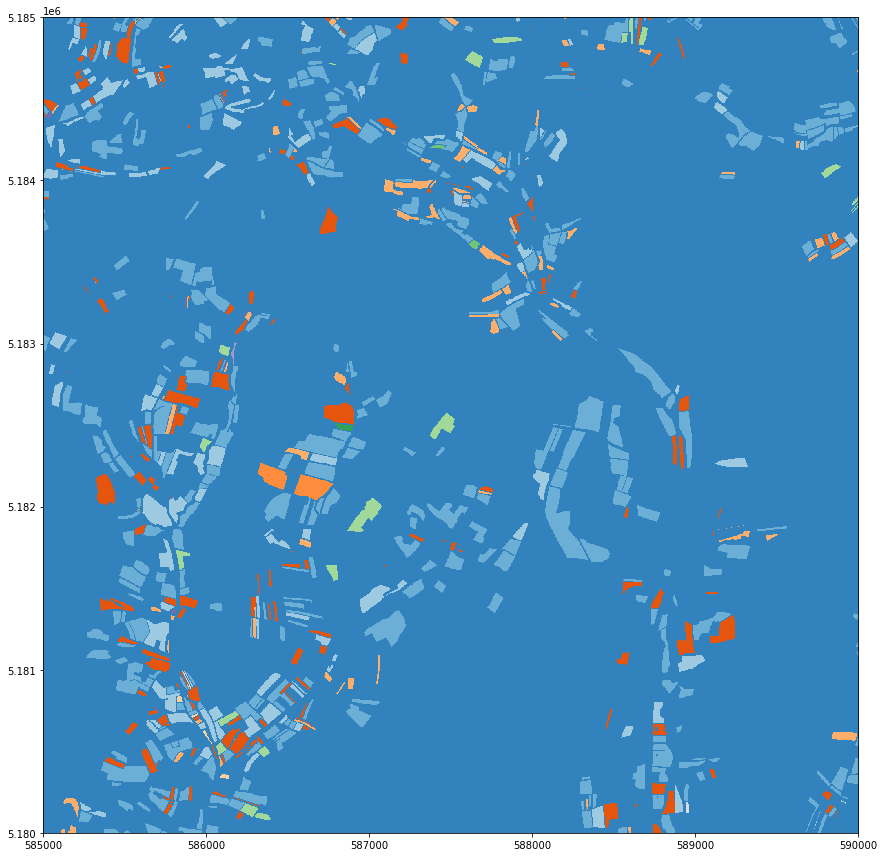

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(eop.mask_timeless['CULTIVATED'].squeeze(), 
          vmin=0, vmax=30, extent=get_extent(eop), 
          interpolation='nearest', cmap=plt.cm.tab20c);

The above tasks rasterise polygons assigning to pixels their `label` values. We add a task that turns the `CULTIVATED` and `NOT_DECLARED` masks into binary masks. 

In [40]:
class ToBinary(EOTask):
    """ Turn a discrete feature to a binary mask """
    def __init__(self, feature: Tuple[FeatureType, str]):
        """ 
        :param feature: Feature in eopatch to binarise 
        """
        self.feature = feature
        
    def execute(self, eopatch: EOPatch) -> EOPatch:
        """ Over-write existing feature with binary mask """
        eopatch[self.feature] = eopatch[self.feature]>0
        return eopatch

In [41]:
valid_to_binary = ToBinary((FeatureType.MASK_TIMELESS, 'CULTIVATED'))
invalid_to_binary = ToBinary((FeatureType.MASK_TIMELESS, 'NOT_DECLARED'))

In [42]:
eop = valid_to_binary.execute(eop)
eop = invalid_to_binary.execute(eop)

In [43]:
eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=6224, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seco

Display target binary _cultivated land_ map, overlayed with the original polygons.

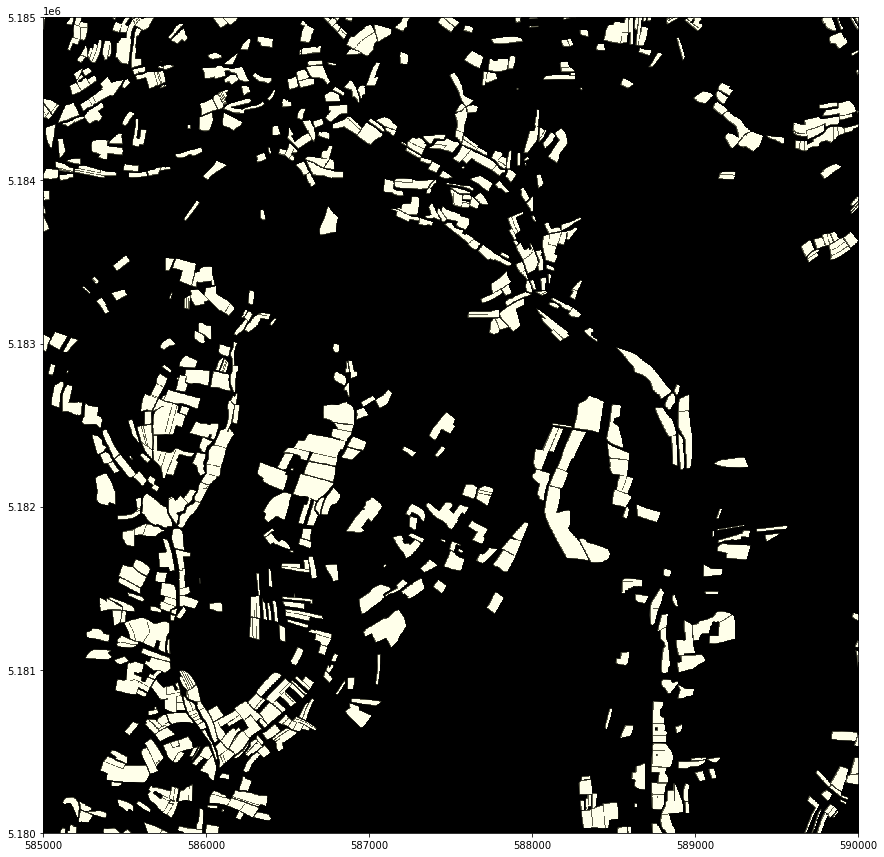

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(eop.mask_timeless['CULTIVATED'], 
          interpolation='nearest', 
          cmap=plt.cm.binary_r, extent=get_extent(eop));
df[df.label.isin(cultivated_mapping[1])].plot(ax=ax, 
                                              color='xkcd:ivory', 
                                              alpha=.4, 
                                              linewidth=.5);

### 1.4 Data download <a name="data-download"></a>

We can now create a workflow that downloads and processes the data as shown above, and parallelize the workflow over the 125 bounding boxes.

In [45]:
# change this path accordingly to your set-up
EOPATCHES_PATH = '../eopatches'
EOPATCHES_TRAIN_PATH = f'{EOPATCHES_PATH}/train/'
EOPATCHES_TEST_PATH = f'{EOPATCHES_PATH}/test/'

if not os.path.exists(EOPATCHES_TRAIN_PATH):
    os.makedirs(EOPATCHES_TRAIN_PATH, exist_ok=True)

if not os.path.exists(EOPATCHES_TEST_PATH):
    os.makedirs(EOPATCHES_TEST_PATH, exist_ok=True)

Task to save the `EOPatch`es to disk for further processing.

In [46]:
save = SaveTask(path=EOPATCHES_PATH, compress_level=2)

The previous steps are combined into a linear workflow, performing S2 data download, adding the reference polygons, rasterising the polygons to rasters, creating binary masks and saving the eopatches to disk.

In [47]:
workflow = LinearWorkflow(get_s2_l2a, 
                          get_polys, 
                          valid_polys_to_mask,
                          invalid_polys_to_mask,
                          all_polys_to_mask,
                          valid_to_binary,
                          invalid_to_binary, 
                          save)

In [48]:
execution_args = []

for irow, row in tqdm(bboxes.iterrows(), total=len(bboxes)):
    bbox = BBox(row.geometry, crs=CRS(bboxes.crs))
    eopatch_folder = f'{"train" if row.is_train else "test"}/eopatch-{row.eop_index}'
    
    eop_exec_args = {get_s2_l2a: {'bbox': bbox, 'time_interval': S2_TIME_INTERVAL},
                     save: {'eopatch_folder': eopatch_folder}}
    
    execution_args.append(eop_exec_args)


  0%|          | 0/125 [00:00<?, ?it/s]

In [49]:
execution_args[:3]

[{<eolearn.io.sentinelhub_process.SentinelHubInputTask at 0x7f9358a78bd0>: {'bbox': BBox(((585000.0, 5180000.0), (590000.0, 5185000.0)), crs=CRS('32633')),
   'time_interval': ('2019-03-01', '2019-09-01')},
  <eolearn.core.core_tasks.SaveTask at 0x7f933a43a910>: {'eopatch_folder': 'test/eopatch-895'}},
 {<eolearn.io.sentinelhub_process.SentinelHubInputTask at 0x7f9358a78bd0>: {'bbox': BBox(((510000.0, 5120000.0), (515000.0, 5125000.0)), crs=CRS('32633')),
   'time_interval': ('2019-03-01', '2019-09-01')},
  <eolearn.core.core_tasks.SaveTask at 0x7f933a43a910>: {'eopatch_folder': 'test/eopatch-615'}},
 {<eolearn.io.sentinelhub_process.SentinelHubInputTask at 0x7f9358a78bd0>: {'bbox': BBox(((535000.0, 5120000.0), (540000.0, 5125000.0)), crs=CRS('32633')),
   'time_interval': ('2019-03-01', '2019-09-01')},
  <eolearn.core.core_tasks.SaveTask at 0x7f933a43a910>: {'eopatch_folder': 'train/eopatch-738'}}]

Parallelise the workflow over the workers. Change `NUM_WORKERS` according to your set-up.

In [ ]:
NUM_WORKERS = 4

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=NUM_WORKERS)

In [ ]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

**NOTE:** check the report file to see if any execution failed. You can repeat the `executor` run including only the `execution_args` of the failed `EOPatch`es.

**NOTE:** now that all data has been saved to disk, there is no need to run the code above for download. To read the `EOPatch`es, simply use the `LoadTask` as follows.

In [50]:
load = LoadTask(path=EOPATCHES_PATH)

In [51]:
eop_rand = bboxes.sample(n=1).iloc[0]

eop_folder = f'{"train" if eop_rand.is_train else "test"}/eopatch-{eop_rand.eop_index}'

reop = load.execute(eopatch_folder=eop_folder)

In [52]:
reop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['label', 'geometry'], length=3977, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datet

### 1.5 Files check <a name="files-check"></a>

Whether you downloaded the data through the APIs or direct link, best to check that all data has been correctly retrieved.

The following code encodes each downloaded numpy file as MD5 hash and compares them to the target MD5 hashes provided in the `metadata` folder. It should take few minutes to compute.

In [52]:
md5_hashes = md5_encode_files(EOPATCHES_PATH)

  0%|          | 0/1125 [00:00<?, ?it/s]

If the following fails, there are some issues with the downloaded files.

In [55]:
assert md5_hashes.equals(pd.read_csv('metadata/hashed-md5-files.csv', 
                                     usecols=['filename', 'hash']))

## 2. Data Processing <a name="data-processing"></a>

This section offers some tips and pointers on how to possibly transform the data in a ML-ready format.

Possible steps are:

 * filter out invalid frames due to clouds/shadows/snow;
 * sample or generate the same number of S2 time-frames for all EOPatches;
 * sample smaller image chips from S2 time-series with corresponding target binary _cultivated land_ map.
 
If you want to use `eo-learn` for these tasks, check out the documentation about existing tasks like filtering and pixel sampling [here](https://eo-learn.readthedocs.io/en/latest/eotasks.html). You can easily implement your own task (as done above) by following [this example](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOTask). [Here](https://github.com/sentinel-hub/eo-learn/tree/master/examples) you can find a collection of examples including land cover and crop-type classification.

Below we provide a custom task to sample patchlets/image chips from the Sentinel-2 time-series and the reference map.

In [55]:
class SamplePatchlets(EOTask):

    SCALE_FACTOR = 4

    def __init__(self, s2_patchlet_size: int, num_samples: int):
        """ Set-up of task 
        
        :param s2_patchlet_size: Size in pixels of resulting patchlet
        :param num_samples: Number of patchlets to sample
        """
        self.s2_patchlet_size = s2_patchlet_size
        self.num_samples = num_samples

    def _calculate_sampled_bbox(self, 
                                bbox: BBox, 
                                r: int, c: int, s: int,
                                resolution: float) -> BBox:
        """ Calculate bounding box of smaller patchlets """
        return BBox(((bbox.min_x + resolution * c,  bbox.max_y - resolution * (r + s)),
                     (bbox.min_x + resolution * (c + s), bbox.max_y - resolution * r)),
                    bbox.crs)

    def _sample_s2(self, 
                   eop: EOPatch, 
                   row: int, col: int, size: int, 
                   resolution: float = 10):
        """ Randomly sample a patchlet from the EOPatch """
        # create a new eopatch for each sub-sample
        sampled_eop = EOPatch(timestamp=eop.timestamp, 
                              scalar=eop.scalar, 
                              meta_info=eop.meta_info)
        
        # sample S2-related arrays
        features = eop.get_feature_list()
        s2_features = [feature for feature in features 
                       if isinstance(feature, tuple) and 
                       (feature[0].is_spatial() and feature[0].is_time_dependent())]
        
        for feature in s2_features:
            sampled_eop[feature] = eop[feature][:, row:row + size, col:col + size, :]
        
        # calculate BBox for new sub-sample
        sampled_eop.bbox = self._calculate_sampled_bbox(eop.bbox, 
                                                        r=row, c=col, s=size, 
                                                        resolution=resolution)
        sampled_eop.meta_info['size_x'] = size
        sampled_eop.meta_info['size_y'] = size
        
        # sample from target maps, beware of `4x` scale factor
        target_features = eop.get_feature(FeatureType.MASK_TIMELESS).keys()
        
        for feat_name in target_features:
            sampled_eop.mask_timeless[feat_name] = \
            eop.mask_timeless[feat_name][self.SCALE_FACTOR*row:self.SCALE_FACTOR*row + self.SCALE_FACTOR*size, 
                                         self.SCALE_FACTOR*col:self.SCALE_FACTOR*col + self.SCALE_FACTOR*size]
        
        return sampled_eop

    def execute(self, eopatch_s2: EOPatch, buffer: int=0,  seed: int=42) -> List[EOPatch]:
        """ Sample a number of patchlets from the larger EOPatch. 
        
        :param eopatch_s2: EOPatch from which patchlets are sampled
        :param buffer: Do not sample in a given buffer at the edges of the EOPatch
        :param seed: Seed to initialise the pseudo-random number generator
        """
        _, n_rows, n_cols, _ = eopatch_s2.data['BANDS'].shape
        np.random.seed(seed)
        eops_out = []
        
        # random sampling of upper-left corner. Change this for non-overlapping patchlets
        for patchlet_num in range(0, self.num_samples):
            row = np.random.randint(buffer, n_rows - self.s2_patchlet_size - buffer)
            col = np.random.randint(buffer, n_cols - self.s2_patchlet_size - buffer)
            sampled_s2 = self._sample_s2(eopatch_s2, row, col, self.s2_patchlet_size)
            eops_out.append(sampled_s2)
        return eops_out

In [56]:
sample_task = SamplePatchlets(s2_patchlet_size=32, num_samples=4)

In [57]:
samples = sample_task.execute(eop)

In [58]:
len(samples)

4

Let's check a sample

In [59]:
samples[0]

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 32, 32, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 32, 32, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(128, 128, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(128, 128, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(128, 128, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 32
    size_y: 32
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((589350.0, 5183660.0), (58

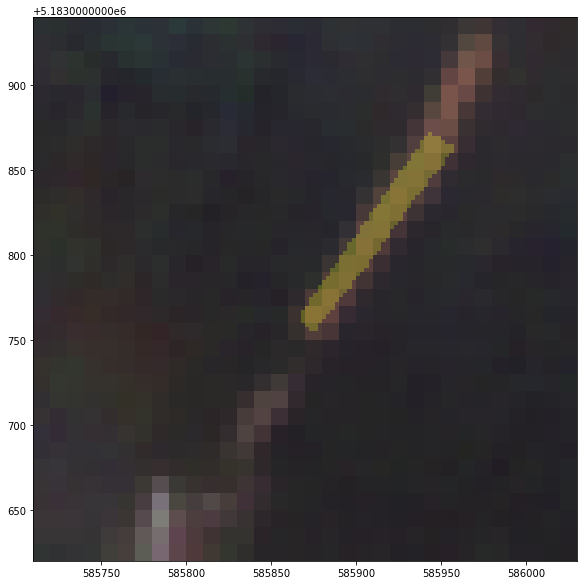

In [60]:
tidx = 28
sample = samples[2]
norm_fact = sample.scalar['NORM_FACTORS'][tidx]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(3.5*sample.data['BANDS'][tidx][..., [3,2,1]]*norm_factor, 
          extent=get_extent(sample));
ax.imshow(sample.mask_timeless['CULTIVATED'].squeeze(), 
          vmin=0, vmax=1, alpha=.2, 
          extent=get_extent(sample));

## 3. Submission Example <a name="submission-example"></a>

A valid submission entails submitting a zipped folder containing a tiff file for each of the 25 test bounding boxes at the target **2.5m** resolution, meaning a `2000x2000` pixels binary raster for each test bounding box.

The `.tif` file should be in the `epsg:32633` coordinate reference system, as the data provided, and should be named as the corresponding `EOPatch`, i.e. `eopatch-81.tif`. Check-out the [`ExportToTiff`](https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiff) task to export a feature to  a tif file. The task uses [rasterio](https://rasterio.readthedocs.io/en/latest/topics/writing.html).

The following code shows how to generate a valid submission using a dummy thresholding method.

### 3.1 Prepare a submission <a name="prepare-a-submission"></a>

The following code shows how to run a simple workflow to export the predicted masks for submission. 

The workflow applies the following:

 * reads `EOPatch` from disk and transforms DNs to reflectances
 * filters time-frames based on `CLM` and `IS_DATA` masks
 * computes NDVI and mean NDVI over the filtered timeframes
 * upscales the mean NDVI to the target spatial resolution of 2.5m
 * applies a thresholding on upscaled mean NDVI
 * exports predicted binary mask
 
The workflow is applied on test EOPatches since they are the only files evaluated.

In your method of course you will make use of the training data to develop a machine learning model, and apply the model to the test patches for the prediciton only.

In [61]:
SUBMISSION_DIR = '../submission'

if not os.path.exists(SUBMISSION_DIR):
    os.makedirs(SUBMISSION_DIR)

In [62]:
import cv2

from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.io import ExportToTiff 

In [63]:
class ComputeReflectances(EOTask):
    """ Apply normalisation factors to DNs """
    def __init__(self, feature):
        self.feature = feature
        
    def execute(self, eopatch):
        eopatch[self.feature] = eopatch.scalar['NORM_FACTORS'][..., None, None] * eopatch[self.feature].astype(np.float32)
        return eopatch

class SentinelHubValidData:
    """
    Combine 'CLM' mask with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

    
class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

    
class MeanNDVI(EOTask):
    """
    Compute the mean temporal NDVI
    """
    def __init__(self, ndvi_feature, mean_ndvi_feature):
        self.ndvi_feature = ndvi_feature
        self.mean_ndvi_feature = mean_ndvi_feature
        
    def execute(self, eopatch):
        eopatch[self.mean_ndvi_feature] = np.nanmean(eopatch[self.ndvi_feature], axis=0)
        return eopatch
    

class Enhance(EOTask):
    """
    Upscale S2 to target resolution
    """
    def __init__(self, feature_in, feature_out, scale_factor=4):
        self.feature_in = feature_in
        self.feature_out = feature_out
        self.scale_factor = scale_factor
        
    def execute(self, eopatch):
        array_in = eopatch[self.feature_in]
        if array_in.ndim == 4:
            array_out = np.concatenate([cv2.resize(arr.squeeze(), 
                                                   None,
                                                   fx=self.scale_factor, 
                                                   fy=self.scale_factor, 
                                                   interpolation = cv2.INTER_CUBIC) 
                                        for arr in array_in])
        elif array_in.ndim == 3:
            array_out = cv2.resize(array_in.squeeze(), None, 
                                   fx=self.scale_factor, 
                                   fy=self.scale_factor, 
                                   interpolation = cv2.INTER_CUBIC) 
        eopatch[self.feature_out] = array_out[..., np.newaxis]
        return eopatch
    

class Classify(EOTask):
    """ Threshold mean NDVI mask """
    def __init__(self, feature_in, feature_out, low_cut=-1., high_cut=1.):
        self.feature_in = feature_in
        self.feature_out = feature_out
        self.low_cut = low_cut
        self.high_cut = high_cut
        
    def execute(self, eopatch):
        array_in = eopatch[self.feature_in]
        
        new_eopatch = EOPatch(bbox=eopatch.bbox)
        
        new_eopatch[self.feature_out] = np.logical_and(array_in > self.low_cut, 
                                                       array_in <= self.high_cut).astype(np.uint8)
        return new_eopatch

In [77]:
band_names = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

# LOAD EOPATCH
load = LoadTask(path=EOPATCHES_PATH)

# COMPUTE REFLECTANCES FROM DNs
normalise = ComputeReflectances((FeatureType.DATA, 'BANDS'))

# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), 
                                     (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), 
                                      band_names.index('B04')])

# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask('IS_VALID', 'VALID_COUNT')

# FILTER OUT CLOUDY SCENES
# Keep frames with > 95% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.95)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# COMPUTE MEAN TEMPORAL NDVI
# Compute mean NDVI values over the time-series
mean_ndvi = MeanNDVI((FeatureType.DATA, 'NDVI'), 
                     (FeatureType.DATA_TIMELESS, 'MEAN_NDVI'))

# UPSCALE MEAN NDVI USING BICUBIC INTERPOLATION
# Apply the 4x upscaling by using bicubic interpolation
enhance = Enhance((FeatureType.DATA_TIMELESS, 'MEAN_NDVI'),
                  (FeatureType.DATA_TIMELESS, 'BIG_MEAN_NDVI'))

# THRESHOLD UPSCALED MEAN NDVI
# Apply thesholds to upscaled mean NDVI
classify = Classify((FeatureType.DATA_TIMELESS, 'BIG_MEAN_NDVI'),
                    (FeatureType.MASK_TIMELESS, 'PREDICTION'),
                    low_cut=.4, high_cut=.6)

# EXPORT PREDICTION AS TIFF
# Export the predicted binary mask as tiff for submission
export = ExportToTiff(feature=(FeatureType.MASK_TIMELESS, 'PREDICTION'),
                      folder=SUBMISSION_DIR, crs='epsg:32633',
                      image_dtype=np.uint8)

In [65]:
dummy_workflow = LinearWorkflow(load, 
                                normalise,
                                ndvi,
                                add_sh_validmask,
                                add_valid_count,
                                filter_task,
                                mean_ndvi,
                                enhance,
                                classify,
                                export)

In [66]:
execution_args = []

for eop_test in tqdm(eops_test):
    eop_exec_args = {load: {'eopatch_folder': f'test/eopatch-{eop_test}'},
                     export: {'filename': f'eopatch-{eop_test}.tif'}}
    
    execution_args.append(eop_exec_args)

  0%|          | 0/25 [00:00<?, ?it/s]

In [67]:
NUM_WORKERS = 4

executor = EOExecutor(dummy_workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=NUM_WORKERS)

  0%|          | 0/25 [00:00<?, ?it/s]

/home/devis/anaconda3/envs/geodb-37/lib/python3.7/site-packages/eolearn/features/bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)
/home/devis/anaconda3/envs/geodb-37/lib/python3.7/site-packages/eolearn/features/bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)
/home/devis/anaconda3/envs/geodb-37/lib/python3.7/site-packages/eolearn/features/bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)
/home/devis/anaconda3/envs/geodb-37/lib/python3.7/site-packages/eolearn/features/bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.a

In [68]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

Using matplotlib backend: TkAgg
Report was saved to location: ./eoexecution-report-2021_05_04-14_59_36/report.html


In [69]:
!ls {SUBMISSION_DIR}

eopatch-322.tif  eopatch-664.tif  eopatch-853.tif  eopatch-883.tif
eopatch-338.tif  eopatch-710.tif  eopatch-854.tif  eopatch-895.tif
eopatch-382.tif  eopatch-757.tif  eopatch-861.tif  eopatch-906.tif
eopatch-384.tif  eopatch-802.tif  eopatch-864.tif  eopatch-917.tif
eopatch-579.tif  eopatch-81.tif   eopatch-865.tif
eopatch-591.tif  eopatch-824.tif  eopatch-866.tif
eopatch-615.tif  eopatch-836.tif  eopatch-876.tif


**NOTE:** you can now zip the `submission` folder and submit it for evaluation.